In [2]:
# --- CRITICAL FIX: Set Environment Variable ---
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
# ---------------------------------------------

import re
import pandas as pd
import tensorflow as tf
import tf_keras # Import the new Keras package
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AutoConfig
from huggingface_hub import hf_hub_download
import warnings
from google.colab import drive, files

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)

print(f"Using TensorFlow version: {tf.__version__}")
import transformers
print(f"Using Transformers version: {transformers.__version__}")

# --- 1. Mount Drive ---
print("\nMounting Google Drive...")
drive.mount('/content/drive')

# --- 2. Upload CSV ---
print("\nPlease upload your 'total_df.csv' file:")
uploaded_csv = files.upload()
total_df_path = list(uploaded_csv.keys())[0]

# --- 3. Set Paths ---
dataset_path = "/content/drive/MyDrive/DAICWOZ_MAIN"
model_name = "distilbert-base-uncased"
print(f"\nCSV path set to: {total_df_path}")
print(f"Dataset path set to: {dataset_path}")

# --- 4. VITAL CHECK ---
print("\nChecking for data at Drive path:")
!ls -l "{dataset_path}" | head -n 10

Using TensorFlow version: 2.19.0
Using Transformers version: 4.57.1

Mounting Google Drive...
Mounted at /content/drive

Please upload your 'total_df.csv' file:


Saving total_df.csv to total_df.csv

CSV path set to: total_df.csv
Dataset path set to: /content/drive/MyDrive/DAICWOZ_MAIN

Checking for data at Drive path:
total 760
drwx------ 2 root root 4096 Oct 22 13:47 300_P
drwx------ 2 root root 4096 Oct 22 13:47 301_P
drwx------ 2 root root 4096 Oct 22 13:47 302_P
drwx------ 2 root root 4096 Oct 22 13:47 303_P
drwx------ 2 root root 4096 Oct 22 13:47 304_P
drwx------ 2 root root 4096 Oct 22 13:47 305_P
drwx------ 2 root root 4096 Oct 22 13:47 306_P
drwx------ 2 root root 4096 Oct 22 13:47 307_P
drwx------ 2 root root 4096 Oct 22 13:47 308_P


In [3]:
def parse_daicwoz_transcript(filepath):
    """
    Parses the DAIC-WOZ transcript file.
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    header = ['start_time', 'stop_time', 'speaker', 'value']
    rows = []
    for line in lines[1:]:  # Skip header row in file
        try:
            line_split = re.split(r'\t| {2,}', line.strip())
            if len(line_split) == 4:
                rows.append(line_split)
            elif len(line_split) > 4:
                rows.append(line_split[:3] + [' '.join(line_split[3:])])
            else:
                line_split_alt = re.split(r'\s+', line.strip())
                if len(line_split_alt) >= 4:
                    rows.append(line_split_alt[:4])
        except Exception as e:
            print(f"Skipping line in {filepath} due to error: {e}. Line: {line}")

    df = pd.DataFrame(rows, columns=header)
    return df

def load_all_transcripts(parent_dir):
    """
    Iterates through all session folders, parses transcripts,
    and extracts only 'Participant' text.
    """
    print(f"Loading all transcripts from: {parent_dir}")
    texts, participant_ids = [], []

    if not os.path.exists(parent_dir):
        print(f"ERROR: The directory '{parent_dir}' does not exist.")
        return pd.DataFrame()

    session_list = [f for f in os.listdir(parent_dir) if os.path.isdir(os.path.join(parent_dir, f)) and f.endswith('_P')]

    for session_folder in session_list:
        session_path = os.path.join(parent_dir, session_folder)
        participant_id = session_folder.split('_')[0]

        try:
            transcript_file_name = [f for f in os.listdir(session_path) if 'TRANSCRIPT' in f and f.endswith('.csv')][0]
            transcript_filepath = os.path.join(session_path, transcript_file_name)
        except IndexError:
            print(f"Warning: No '...TRANSCRIPT.csv' file found in {session_folder}. Skipping.")
            continue

        try:
            df_t = parse_daicwoz_transcript(transcript_filepath)
            utterances = df_t[df_t['speaker'].str.strip().str.lower() == 'participant']['value'].dropna().astype(str).tolist()

            if not utterances:
                print(f"Warning: No participant utterances found for {participant_id}. Skipping.")
                continue

            full_text = " ".join(utterances)
            texts.append(full_text)
            participant_ids.append(participant_id)

        except Exception as e:
            print(f"Error parsing transcript for {participant_id}: {e}")

    print(f"Successfully loaded and processed {len(texts)} transcripts.")
    return pd.DataFrame({
        "participant_id": participant_ids,
        "text": texts
    })

# --- Execute Data Loading ---
text_df = load_all_transcripts(dataset_path)

if not text_df.empty:
    print(f"Loading labels from {total_df_path}...")

    labels_df = pd.read_csv(total_df_path)

    print(f"Merging {len(text_df)} transcripts with {len(labels_df)} labels.")
    text_df['participant_id'] = text_df['participant_id'].astype(str)
    labels_df['Participant_ID'] = labels_df['Participant_ID'].astype(str)

    df = pd.merge(text_df, labels_df, left_on='participant_id', right_on='Participant_ID')

    df = df[['participant_id', 'text', 'PHQ8_Binary']]
    df = df.rename(columns={'PHQ8_Binary': 'label'})
    df = df.dropna(subset=['label'])
    df['label'] = df['label'].astype(int)

    print("\nData loading complete. DataFrame head:")
    print(df.head())
    print(f"\nTotal records loaded: {len(df)}")
    print("\nData distribution:")
    print(df['label'].value_counts())
else:
    print("Data loading failed. Please check your path in Step 3.")

Loading all transcripts from: /content/drive/MyDrive/DAICWOZ_MAIN
Successfully loaded and processed 189 transcripts.
Loading labels from total_df.csv...
Merging 189 transcripts with 189 labels.

Data loading complete. DataFrame head:
  participant_id                                               text  label
0            490  <synch> yeah i'm doing already how are you doi...      0
1            486  <synch> yes i'm feel great i am from saint lou...      0
2            492  <synch> yes doing pretty good thank you maryla...      0
3            488  <synch> yes fine oh san fernando valley uh wel...      0
4            489  <synch> yes i'm doing well thank you san luis ...      0

Total records loaded: 189

Data distribution:
label
0    133
1     56
Name: count, dtype: int64


In [4]:
# --- We need to import EarlyStopping here ---
from tf_keras.callbacks import EarlyStopping
# --- THIS IS THE NEW LINE I FORGOT ---
from sklearn.utils.class_weight import compute_class_weight
# -------------------------------------

print("\nPreprocessing data...")
# Split the data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

# --- Calculate Class Weights to fix accuracy ---
print("Calculating class weights to handle imbalance...")
class_weights_array = compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weight_dict = {i : class_weights_array[i] for i, cls in enumerate(np.unique(train_labels))}
print(f"Class Weights calculated: {class_weight_dict}")
# --------------------------------------------------

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize the text
train_enc = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
test_enc = tokenizer(test_texts, truncation=True, padding=True, max_length=256)

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((dict(train_enc), train_labels)).shuffle(1000).batch(8)
test_ds = tf.data.Dataset.from_tensor_slices((dict(test_enc), test_labels)).batch(8)
print("Data preprocessing complete.")

print("\nBuilding and training model...")

# --- We use the proven, working manual load for distilbert ---
print("Loading model config...")
config = AutoConfig.from_pretrained(model_name, num_labels=2)
print("Creating model from config...")
model = TFAutoModelForSequenceClassification.from_config(config)
print("Downloading TensorFlow weights...")
weights_path = hf_hub_download(repo_id=model_name, filename="tf_model.h5")
print("Building model variables...")
dummy_input = {
    'input_ids': tf.zeros((8, 256), dtype=tf.int32),
    'attention_mask': tf.zeros((8, 256), dtype=tf.int32)
}
_ = model(dummy_input)
print("Model variables built.")
print(f"Loading weights from {weights_path}...")
model.load_weights(weights_path, by_name=True, skip_mismatch=True)
print("Model loaded successfully.")
# -----------------------------------------------------------

# --- We use 'tf_keras' as required ---
optimizer = tf_keras.optimizers.Adam(learning_rate=3e-5)
loss_fn = tf_keras.losses.SparseCategoricalCrossentropy(from_logits=True)
acc_metric = tf_keras.metrics.SparseCategoricalAccuracy(name="accuracy")
# ---------------------------------------

model.compile(optimizer=optimizer, loss=loss_fn, metrics=[acc_metric])

# --- Use EarlyStopping to prevent overfitting ---
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=2, # Give it 2 epochs to recover
    restore_best_weights=True
)
# ------------------------------------------

epochs = 10
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    # --- Pass both the callback AND the class weights ---
    callbacks=[early_stopping_callback],
    class_weight=class_weight_dict
)

print("Model training complete.")


Preprocessing data...
Calculating class weights to handle imbalance...
Class Weights calculated: {0: np.float64(0.7122641509433962), 1: np.float64(1.6777777777777778)}


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Data preprocessing complete.

Building and training model...
Loading model config...
Creating model from config...


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


tf_model.h5:   0%|          | 0.00/363M [00:00<?, ?B/s]

Building model variables...
Model variables built.
Loading weights from /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/tf_model.h5...
Model loaded successfully.
Epoch 1/10
19/19 [==============================] - 358s 17s/step - loss: 0.7077 - accuracy: 0.4503 - val_loss: 0.6997 - val_accuracy: 0.2895
Epoch 2/10
19/19 [==============================] - 306s 16s/step - loss: 0.6865 - accuracy: 0.4503 - val_loss: 0.6927 - val_accuracy: 0.5526
Epoch 3/10
19/19 [==============================] - 307s 16s/step - loss: 0.6721 - accuracy: 0.6755 - val_loss: 0.8591 - val_accuracy: 0.2895
Epoch 4/10
19/19 [==============================] - 302s 16s/step - loss: 0.5932 - accuracy: 0.7020 - val_loss: 0.6010 - val_accuracy: 0.7105
Epoch 5/10
19/19 [==============================] - 304s 16s/step - loss: 0.3530 - accuracy: 0.8940 - val_loss: 0.7486 - val_accuracy: 0.6316
Epoch 6/10
19/19 [==============================] - 303s 16s/ste

In [5]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



--- Model Performance ---
Evaluating model on the test set...
5/5 [==============================] - 27s 5s/step - loss: 0.6010 - accuracy: 0.7105
Test Loss: 0.6010
Test Accuracy: 0.7105


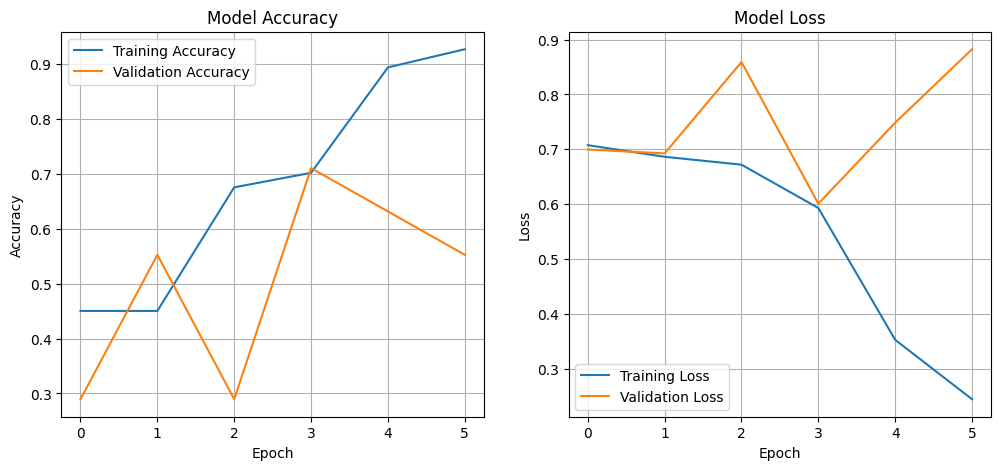


--- Test Set Classification Report ---
3/5 [=================>............] - ETA: 8s 

In [ ]:
# --- We'll import seaborn here, right where we need it ---
import seaborn as sns
# --------------------------------------------------------

print("\n--- Model Performance ---")

# --- 1. Explicitly evaluate on the test set ---
print("Evaluating model on the test set...")
test_results = model.evaluate(test_ds)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
# ----------------------------------------------

# --- 2. Plot Training & Validation Accuracy/Loss ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

# --- 3. Get Classification Report ---
print("\n--- Test Set Classification Report ---")
predictions = model.predict(test_ds)
y_pred = np.argmax(tf.nn.softmax(predictions.logits, axis=-1), axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

target_names = ['NO (Not Depressed)', 'YES (Depressed)']
print(classification_report(y_true, y_pred, target_names=target_names))

# --- 4. NEW: Plot Confusion Matrix with Seaborn ---
print("--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm,
            annot=True, # Show numbers in the squares
            fmt='d', # Format as integers
            cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
save_directory = "/content/my_depression_model"

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model saved to {save_directory}")

!zip -r /content/my_depression_model.zip /content/my_depression_model

print("\nModel zipped. You can download 'my_depression_model.zip' from the file panel on the left.")